# OpenAI Gym


In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

Exception ignored in: <function _xla_gc_callback at 0x11ae9c5e0>
Traceback (most recent call last):
  File "/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x11ae9c5e0>
Traceback (most recent call last):
  File "/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp7xh6cj6n
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmp7xh6cj6n/_remote_module_non_scriptable.py


## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

MountainCar | CartPole
- | - 
![mountaincar.gif](https://www.gymlibrary.dev/_images/mountain_car.gif) | ![cart_pole.gif](https://www.gymlibrary.dev/_images/cart_pole.gif)

## Hyperparameters

In [28]:
name = 'gymtesty'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 20000  # total timesteps
    T0 = 4000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 1
    ds = 4
    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    make_system = lambda : Gym(env_name=env_name, repeat=1, max_episode_len=600, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------
    
    dl = 6
    
#     observable = TimeDelayedObservation(hh = 4, state_dim=ds, control_dim=du, 
#                                         use_states=False, use_controls=True, 
#                                         use_costs=True, use_cost_diffs=True,
#                                         use_time=False)
#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED)
#     observable = FullObservation(state_dim=ds)
    if env_name == 'CartPoleContinuous-v1':
        assert ds == 4 and du == 1
        def cartpole_obs_func(traj: Trajectory):
            obs = traj.x[-1]
            obs.at[0].set(obs[0] / 10)
            obs.at[1].set(obs[1] / 100)
            obs.at[3].set(obs[3] / 100)
            return obs
        observable = Observable(obs_func=cartpole_obs_func, obs_dim=ds)
        
    do = observable.obs_dim
    
    exploration_args = {'scales': 0.7, 'avg_len': 3,}
    sysid_args = {
        'obs_dim': do,
        'control_dim': du,

        'max_traj_len': int(1e6),
        
        'exploration_args': {'random 0.75': exploration_args,
                             'impulse 0.25': exploration_args,
                            },
        
        'AB_method': 'regression_nograd',
        
        'depth': 6,
        'sigma': 0,
        'determinstic_encoder': True,
        'num_epochs': 6000,
        'lifter_lr': 0.001,                                                           

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 4  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.000, betas=(0.9, 0.999))
#     m0_update_rescaler = lambda : FIXED_RESCALE(alpha=-0.01, beta=0.999)
    k_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.4, beta=0.6)

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.05, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
#         'Lifted LQR': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=LQR(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, method='nn', **sysid_args), T0=T0),
#         'Lifted HINF': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=HINF(sysid.A, sysid.B), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, method='nn', **sysid_args), T0=T0),
#         'Lifted GPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=GPC(sysid.A, sysid.B, decay=False, lr_scale=0.01, H=10), lifter=sysid),
#                                           sysid=Lifter(state_dim=dl, method='nn', **sysid_args), T0=T0),
        'Lifted EvanBPC': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, method='nn', **sysid_args), T0=T0)
    }

    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [29]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted EvanBPC
INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.75000006 0.25      ]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 4876/5000 [00:04<00:00, 1101.00it/s]
5001it [00:04, 1100.93it/s]                                                                                                                          
INFO: (PC3): we are imposing simplification as a hard constraint via isometric NN
INFO: (PC3): using "regression_nograd" method to get the AB matrices during each training step

  0%|                                                                                                                      | 0/20000 [00:00<?, ?it/s]INFO

  0%|                                                                                | 30/20000 [00:00<01:06, 298.12it/s, control=-.222, cost=0.0302]


  0%|▎                                                                               | 90/20000 [00:00<01:06, 298.90it/s, control=-.666, cost=0.0139]


  1%|▌                                                                            | 151/20000 [00:00<01:11, 276.76it/s, control=0.388, cost=0.000617]


  1%|▋                                                                              | 182/20000 [00:00<01:09, 284.47it/s, control=-.41, cost=0.00572]


  1%|▉                                                                            | 244/20000 [00:00<01:07, 294.26it/s, control=-.459, cost=0.000955]


  2%|█▏                                                                             | 302/20000 [00:01<01:15, 262.55it/s, control=-.435, cost=0.0001]


  2%|█▍                                                                            | 358/20000 [00:01<01:13, 268.78it/s, control=0.588, cost=0.00182]


  2%|█▌                                                                            | 387/20000 [00:01<01:11, 274.19it/s, control=0.0235, cost=0.0395]


  2%|█▊                                                                                | 444/20000 [00:01<01:12, 270.81it/s, control=0, cost=2.56e-5]


  3%|██                                                                              | 503/20000 [00:01<01:09, 279.73it/s, control=-.326, cost=0.054]


  3%|██▏                                                                            | 560/20000 [00:02<01:11, 272.06it/s, control=0.547, cost=0.0123]


  3%|██▍                                                                          | 617/20000 [00:02<01:12, 268.06it/s, control=0.306, cost=0.000749]


  3%|██▋                                                                                | 647/20000 [00:02<01:10, 274.82it/s, control=0, cost=0.0106]


  4%|██▊                                                                            | 703/20000 [00:02<01:10, 273.17it/s, control=-.417, cost=0.0374]


  4%|██▉                                                                           | 763/20000 [00:02<01:07, 284.86it/s, control=0.418, cost=0.00904]


  4%|███▏                                                                           | 794/20000 [00:02<01:05, 291.56it/s, control=0.12, cost=2.24e-5]


  4%|███▎                                                                           | 854/20000 [00:03<01:05, 294.50it/s, control=0.209, cost=0.0333]


  5%|███▌                                                                          | 914/20000 [00:03<01:11, 268.19it/s, control=0.535, cost=0.00743]


  5%|███▋                                                                       | 973/20000 [00:03<01:10, 269.42it/s, control=-.00182, cost=0.000737]


  5%|███▊                                                                        | 1001/20000 [00:03<01:12, 263.87it/s, control=0.495, cost=0.000107]


  5%|████                                                                        | 1060/20000 [00:03<01:08, 277.43it/s, control=0.215, cost=0.000178]


  6%|████▌                                                                            | 1119/20000 [00:04<01:10, 268.94it/s, control=0, cost=0.00495]


  6%|████▊                                                                            | 1177/20000 [00:04<01:08, 273.17it/s, control=0.69, cost=0.02]


  6%|████▋                                                                        | 1208/20000 [00:04<01:06, 281.60it/s, control=-.356, cost=0.00875]


  6%|████▉                                                                        | 1269/20000 [00:04<01:04, 289.05it/s, control=-.0247, cost=0.0106]


  7%|█████▏                                                                        | 1326/20000 [00:04<01:09, 267.31it/s, control=0.22, cost=0.00386]


  7%|█████▎                                                                       | 1383/20000 [00:05<01:08, 273.48it/s, control=0.489, cost=0.00358]


  7%|█████▋                                                                           | 1414/20000 [00:05<01:05, 282.50it/s, control=0, cost=0.00212]


  7%|█████▋                                                                       | 1475/20000 [00:05<01:03, 293.02it/s, control=0.186, cost=0.00233]


  8%|█████▉                                                                        | 1536/20000 [00:05<01:02, 296.92it/s, control=0.421, cost=0.0312]


  8%|██████▎                                                                          | 1567/20000 [00:05<01:01, 299.81it/s, control=0, cost=0.00114]


  8%|██████▌                                                                          | 1628/20000 [00:05<01:08, 269.79it/s, control=0, cost=8.09e-5]


  8%|██████▍                                                                      | 1686/20000 [00:06<01:10, 258.61it/s, control=0.599, cost=0.00103]


  9%|███████                                                                          | 1741/20000 [00:06<01:10, 260.80it/s, control=0, cost=0.00528]


  9%|██████▊                                                                      | 1772/20000 [00:06<01:06, 272.70it/s, control=-.679, cost=0.00223]


  9%|███████                                                                      | 1833/20000 [00:06<01:03, 286.92it/s, control=-.651, cost=0.00885]


  9%|███████▎                                                                      | 1891/20000 [00:06<01:07, 269.91it/s, control=0.155, cost=0.0425]


 10%|███████▉                                                                          | 1947/20000 [00:07<01:06, 270.02it/s, control=0, cost=0.0026]


 10%|███████▌                                                                    | 1977/20000 [00:07<01:05, 275.53it/s, control=-.555, cost=0.000327]


 10%|███████▉                                                                      | 2035/20000 [00:07<01:04, 277.62it/s, control=0.287, cost=0.0184]


 10%|████████▍                                                                       | 2095/20000 [00:07<01:06, 268.46it/s, control=0, cost=0.000332]


 11%|████████▋                                                                        | 2152/20000 [00:07<01:05, 274.05it/s, control=0, cost=0.00184]


 11%|████████▍                                                                    | 2180/20000 [00:08<01:05, 273.93it/s, control=-.107, cost=0.00206]


 11%|████████▌                                                                    | 2236/20000 [00:08<01:05, 272.06it/s, control=-.408, cost=0.00381]


 11%|████████▋                                                                   | 2295/20000 [00:08<01:03, 279.52it/s, control=0.579, cost=0.000118]


 12%|█████████                                                                    | 2357/20000 [00:08<01:00, 292.46it/s, control=-.65, cost=0.000157]


 12%|█████████▏                                                                   | 2388/20000 [00:08<00:59, 295.82it/s, control=-.298, cost=0.00113]


 12%|██████████                                                                        | 2449/20000 [00:08<01:04, 272.04it/s, control=0, cost=0.0175]


 13%|██████████                                                                      | 2508/20000 [00:09<01:04, 272.13it/s, control=0, cost=0.000108]


 13%|█████████▉                                                                   | 2566/20000 [00:09<01:04, 270.62it/s, control=0.482, cost=0.00605]


 13%|█████████▊                                                                  | 2596/20000 [00:09<01:02, 278.41it/s, control=0.657, cost=0.000801]


 13%|██████████▏                                                                  | 2658/20000 [00:09<00:59, 291.98it/s, control=-.152, cost=0.00238]


 14%|███████████                                                                      | 2718/20000 [00:09<01:00, 286.76it/s, control=0, cost=0.00881]


 14%|███████████▎                                                                      | 2747/20000 [00:09<01:00, 287.40it/s, control=0, cost=0.0333]


 14%|███████████▏                                                                    | 2808/20000 [00:10<01:08, 249.34it/s, control=0, cost=0.000903]


 14%|███████████▋                                                                      | 2864/20000 [00:10<01:06, 259.31it/s, control=0, cost=0.0353]


 15%|███████████▏                                                                 | 2919/20000 [00:10<01:04, 266.66it/s, control=-.0919, cost=0.0187]


 15%|███████████▌                                                                  | 2975/20000 [00:10<01:03, 269.65it/s, control=-.663, cost=0.0172]


 15%|███████████▋                                                                  | 3005/20000 [00:10<01:01, 277.38it/s, control=-.448, cost=0.0497]


 15%|████████████▍                                                                    | 3064/20000 [00:11<01:03, 268.75it/s, control=0, cost=2.56e-5]


 16%|████████████▋                                                                    | 3122/20000 [00:11<01:00, 277.02it/s, control=0, cost=0.00122]


 16%|████████████▉                                                                    | 3180/20000 [00:11<01:00, 276.69it/s, control=0, cost=0.00224]


 16%|█████████████▏                                                                    | 3212/20000 [00:11<00:58, 287.43it/s, control=0, cost=0.0205]


 16%|████████████▌                                                                | 3274/20000 [00:11<00:56, 295.90it/s, control=-.303, cost=2.94e-5]


 17%|████████████▋                                                               | 3334/20000 [00:12<01:00, 277.53it/s, control=0.402, cost=0.000674]


 17%|█████████████▊                                                                    | 3362/20000 [00:12<01:04, 259.63it/s, control=0, cost=0.0264]


 17%|██████████████                                                                    | 3420/20000 [00:12<01:02, 267.41it/s, control=0, cost=0.0497]


 17%|█████████████                                                              | 3477/20000 [00:12<01:00, 271.01it/s, control=0.0623, cost=0.000483]


 18%|██████████████▎                                                                  | 3539/20000 [00:12<00:57, 288.29it/s, control=0, cost=0.00074]


 18%|██████████████▍                                                                  | 3569/20000 [00:12<00:56, 291.15it/s, control=0, cost=0.00376]


 18%|██████████████▉                                                                   | 3630/20000 [00:13<00:56, 292.20it/s, control=0, cost=0.0349]


 18%|██████████████▏                                                              | 3688/20000 [00:13<01:01, 264.61it/s, control=0.262, cost=2.25e-5]


 19%|███████████████▎                                                                  | 3745/20000 [00:13<01:00, 269.84it/s, control=0, cost=0.0034]


 19%|██████████████▋                                                               | 3773/20000 [00:13<01:00, 270.36it/s, control=0.561, cost=0.0115]


 19%|██████████████▉                                                               | 3833/20000 [00:13<00:57, 283.41it/s, control=-.648, cost=0.0303]


 19%|███████████████▏                                                              | 3894/20000 [00:14<00:55, 292.74it/s, control=-.569, cost=0.0413]


 20%|███████████████                                                              | 3924/20000 [00:14<00:54, 294.71it/s, control=0.0768, cost=0.0442]


 20%|███████████████▌                                                              | 3985/20000 [00:14<00:54, 293.52it/s, control=0.509, cost=0.0249]INFO: (SYSID WRAPPER) ending exploration at timestep 4000
INFO: (LIFTER): ending sysid phase at step 3999
INFO: training!
INFO: mean loss for epochs -600 - 0:
INFO: 		l2 linearization: 0.0009695416665636003
INFO: 		centeredness: 0.0005532536888495088
INFO: mean loss for epochs 0 - 600:
INFO: 		l2 linearization: 9.406475346622755e-06
INFO: 		centeredness: 4.470705862236931e-06
INFO: mean loss for epochs 600 - 1200:
INFO: 		l2 linearization: 3.7208628663165654e-06
INFO: 		centeredness: 4.143806338656001e-07



 20%|███████████████▌                                                              | 3985/20000 [00:33<00:54, 293.52it/s, control=0.509, cost=0.0249]INFO: mean loss for epochs 1200 - 1800:
INFO: 		l2 linearization: 1.0417729206058841e-05
INFO: 		centeredness: 1.6837271145201764e-06
INFO: mean loss for epochs 1800 - 2400:
INFO: 		l2 linearization: 3.0815188122327677e-06
INFO: 		centeredness: 8.661833607940632e-07
INFO: mean loss for epochs 2400 - 3000:
INFO: 		l2 linearization: 6.328478864503495e-07
INFO: 		centeredness: 1.473662644950006e-06
INFO: mean loss for epochs 3000 - 3600:
INFO: 		l2 linearization: 1.0287648478168875e-06
INFO: 		centeredness: 1.5223479802746928e-06
INFO: mean loss for epochs 3600 - 4200:
INFO: 		l2 linearization: 8.330462602993786e-07
INFO: 		centeredness: 1.1100208805222186e-06
INFO: mean loss for epochs 4200 - 4800:
INFO: 		l2 linearization: 5.5295403682246535e-06
INFO: 		centeredness: 9.804662618269806e-07
INFO: mean loss for epochs 4800 - 5400:
INFO: 		l2 l

regression:
||A||_op = 0.9129443764686584
||B||_F = 0.0024410781916230917
||A-BK||_op = 0.9157125949859619

moments:
||A||_op = 0.9629663825035095
||B||_F = 0.0007159928791224957
||A-BK||_op = 0.9629589915275574




 20%|███████████████▏                                                           | 4058/20000 [01:20<1:12:45,  3.65it/s, control=-.0744, cost=0.00374]


 20%|███████████████▌                                                            | 4100/20000 [01:21<28:26,  9.32it/s, control=0.0999, cost=0.000222]


 21%|████████████████▍                                                              | 4149/20000 [01:21<07:45, 34.05it/s, control=-.506, cost=0.0226]


 21%|████████████████▌                                                              | 4201/20000 [01:22<03:48, 69.11it/s, control=-.19, cost=0.00192]


 21%|████████████████▊                                                              | 4247/20000 [01:23<03:22, 77.82it/s, control=0.508, cost=0.0398]


 21%|████████████████▉                                                              | 4294/20000 [01:23<03:19, 78.71it/s, control=-.262, cost=0.0135]


 22%|█████████████████▏                                                             | 4342/20000 [01:24<03:07, 83.68it/s, control=-.768, cost=0.0312]


 22%|█████████████████▎                                                             | 4387/20000 [01:24<03:13, 80.84it/s, control=0.637, cost=0.0408]


 22%|█████████████████▌                                                             | 4434/20000 [01:25<03:12, 80.98it/s, control=-.458, cost=0.0155]


 22%|█████████████████▍                                                            | 4481/20000 [01:26<03:07, 82.82it/s, control=-.362, cost=0.00965]


 23%|█████████████████▉                                                             | 4535/20000 [01:26<03:09, 81.51it/s, control=0.231, cost=0.0131]


 23%|██████████████████▎                                                             | 4580/20000 [01:27<03:07, 82.29it/s, control=0.627, cost=0.019]


 23%|██████████████████▎                                                            | 4627/20000 [01:27<03:12, 79.70it/s, control=-.394, cost=0.0024]


 23%|██████████████████▍                                                            | 4673/20000 [01:28<03:15, 78.56it/s, control=0.287, cost=0.0158]


 24%|█████████████████▉                                                          | 4721/20000 [01:29<03:03, 83.06it/s, control=0.0574, cost=0.000847]


 24%|██████████████████▊                                                            | 4768/20000 [01:29<03:07, 81.20it/s, control=0.172, cost=4.5e-5]


 24%|███████████████████                                                            | 4824/20000 [01:30<03:01, 83.72it/s, control=-.445, cost=0.0121]


 24%|███████████████████▏                                                           | 4870/20000 [01:30<03:03, 82.65it/s, control=-.458, cost=0.0109]


 25%|███████████████████▏                                                          | 4917/20000 [01:31<03:08, 80.07it/s, control=0.188, cost=0.00706]


 25%|██████████████████▊                                                         | 4964/20000 [01:31<03:08, 79.62it/s, control=-.0079, cost=0.000353]


 25%|███████████████████▊                                                           | 5012/20000 [01:32<02:59, 83.73it/s, control=-.588, cost=0.0228]


 25%|███████████████████▍                                                         | 5058/20000 [01:33<03:00, 82.78it/s, control=-.196, cost=0.000278]


 26%|███████████████████▋                                                         | 5105/20000 [01:33<03:06, 79.74it/s, control=0.213, cost=0.000315]


 26%|████████████████████▌                                                           | 5150/20000 [01:34<03:05, 80.25it/s, control=-.68, cost=0.0205]


 26%|████████████████████▊                                                           | 5207/20000 [01:34<03:07, 78.79it/s, control=0.381, cost=0.015]


 26%|████████████████████▏                                                        | 5250/20000 [01:35<03:17, 74.82it/s, control=0.0868, cost=0.00506]


 26%|████████████████████▉                                                          | 5297/20000 [01:36<02:57, 82.91it/s, control=-.559, cost=0.0338]


 27%|█████████████████████▏                                                         | 5350/20000 [01:36<03:10, 76.71it/s, control=0.591, cost=0.0265]


 27%|█████████████████████▎                                                         | 5398/20000 [01:37<02:55, 83.41it/s, control=-.427, cost=0.0237]


 27%|█████████████████████▏                                                        | 5445/20000 [01:37<03:02, 79.94it/s, control=0.123, cost=0.00378]


 27%|█████████████████████▍                                                        | 5491/20000 [01:38<03:01, 79.72it/s, control=-.142, cost=0.00558]


 28%|█████████████████████▉                                                         | 5539/20000 [01:39<02:53, 83.32it/s, control=-.662, cost=0.0311]


 28%|██████████████████████                                                         | 5585/20000 [01:39<02:59, 80.52it/s, control=-.13, cost=1.98e-5]


 28%|██████████████████████▏                                                        | 5632/20000 [01:40<03:00, 79.40it/s, control=0.709, cost=0.0582]


 28%|██████████████████████▏                                                       | 5678/20000 [01:40<03:01, 78.90it/s, control=-.162, cost=0.00287]


 29%|██████████████████████▌                                                        | 5724/20000 [01:41<03:03, 77.98it/s, control=-.495, cost=0.0207]


 29%|██████████████████████▌                                                       | 5777/20000 [01:42<03:17, 71.89it/s, control=-.369, cost=0.00771]


 29%|███████████████████████                                                        | 5823/20000 [01:42<03:02, 77.63it/s, control=0.456, cost=0.0227]


 29%|██████████████████████▌                                                      | 5869/20000 [01:43<02:58, 79.32it/s, control=0.0979, cost=0.00286]


 30%|██████████████████████▍                                                     | 5916/20000 [01:43<02:59, 78.68it/s, control=0.0502, cost=0.000807]


 30%|███████████████████████▎                                                      | 5972/20000 [01:44<02:49, 82.91it/s, control=-.135, cost=0.00648]


 30%|███████████████████████▊                                                       | 6019/20000 [01:45<02:48, 82.90it/s, control=-.553, cost=0.0287]


 30%|████████████████████████▎                                                       | 6065/20000 [01:45<02:53, 80.51it/s, control=-.293, cost=0.013]


 31%|████████████████████████▏                                                      | 6112/20000 [01:46<02:54, 79.58it/s, control=0.309, cost=0.0183]


 31%|████████████████████████                                                      | 6158/20000 [01:46<02:54, 79.19it/s, control=0.137, cost=3.77e-5]


 31%|████████████████████████▌                                                      | 6204/20000 [01:47<02:57, 77.69it/s, control=-.326, cost=0.0193]


 31%|████████████████████████▋                                                      | 6252/20000 [01:48<02:44, 83.64it/s, control=-.473, cost=0.0119]


 31%|████████████████████████▉                                                      | 6299/20000 [01:48<02:47, 81.95it/s, control=0.777, cost=0.0608]


 32%|█████████████████████████                                                      | 6346/20000 [01:49<02:50, 80.05it/s, control=-.14, cost=0.00408]


 32%|█████████████████████████▌                                                      | 6401/20000 [01:49<02:53, 78.20it/s, control=-.64, cost=0.0298]


 32%|█████████████████████████▍                                                     | 6448/20000 [01:50<02:44, 82.19it/s, control=0.185, cost=0.0109]


 32%|█████████████████████████▎                                                    | 6495/20000 [01:51<02:42, 83.17it/s, control=0.483, cost=0.00888]


 33%|█████████████████████████▌                                                    | 6542/20000 [01:51<02:47, 80.37it/s, control=-.133, cost=0.00159]


 33%|██████████████████████████▎                                                     | 6588/20000 [01:52<02:50, 78.69it/s, control=0.46, cost=0.0238]


 33%|█████████████████████████▉                                                    | 6636/20000 [01:52<02:40, 83.19it/s, control=0.128, cost=2.94e-5]


 33%|██████████████████████████                                                    | 6683/20000 [01:53<02:45, 80.39it/s, control=-.28, cost=0.000377]


 34%|██████████████████████████▉                                                     | 6729/20000 [01:54<02:47, 79.20it/s, control=0.24, cost=0.0051]


 34%|██████████████████████████▊                                                    | 6784/20000 [01:54<02:49, 77.97it/s, control=0.574, cost=0.0314]


 34%|██████████████████████████▋                                                   | 6830/20000 [01:55<02:50, 77.31it/s, control=-.127, cost=0.00567]


 34%|██████████████████████████▊                                                   | 6877/20000 [01:55<02:49, 77.23it/s, control=-.218, cost=0.00154]


 35%|███████████████████████████▎                                                   | 6924/20000 [01:56<02:43, 79.77it/s, control=0.495, cost=0.0274]


 35%|██████████████████████████▊                                                  | 6971/20000 [01:57<02:42, 80.19it/s, control=-.0395, cost=0.00532]


 35%|████████████████████████████                                                    | 7018/20000 [01:57<02:43, 79.56it/s, control=-.356, cost=0.011]


 35%|███████████████████████████▌                                                  | 7070/20000 [01:58<02:48, 76.77it/s, control=-.0973, cost=0.0012]


 36%|████████████████████████████                                                   | 7118/20000 [01:58<02:34, 83.18it/s, control=0.536, cost=0.0212]


 36%|████████████████████████████▋                                                   | 7165/20000 [01:59<02:37, 81.54it/s, control=0.3, cost=0.00178]


 36%|████████████████████████████▍                                                  | 7212/20000 [01:59<02:40, 79.64it/s, control=-.558, cost=0.0318]


 36%|████████████████████████████▋                                                  | 7258/20000 [02:00<02:41, 79.06it/s, control=0.175, cost=0.0133]


 37%|████████████████████████████▍                                                 | 7306/20000 [02:01<02:31, 83.81it/s, control=0.251, cost=0.00382]


 37%|█████████████████████████████▍                                                  | 7359/20000 [02:01<02:46, 76.03it/s, control=0.638, cost=0.023]


 37%|████████████████████████████▏                                               | 7402/20000 [02:02<02:48, 74.71it/s, control=0.0986, cost=0.000106]


 37%|█████████████████████████████▍                                                 | 7452/20000 [02:03<02:41, 77.53it/s, control=0.515, cost=0.0066]


 37%|█████████████████████████████▌                                                 | 7498/20000 [02:03<02:38, 79.11it/s, control=-.15, cost=0.00126]


 38%|█████████████████████████████▍                                                | 7544/20000 [02:04<02:39, 78.09it/s, control=0.293, cost=0.00778]


 38%|█████████████████████████████▉                                                 | 7591/20000 [02:04<02:33, 80.60it/s, control=0.377, cost=0.0156]


 38%|█████████████████████████████▊                                                | 7638/20000 [02:05<02:28, 82.98it/s, control=0.272, cost=0.00119]


 38%|██████████████████████████████▍                                                | 7693/20000 [02:06<02:36, 78.76it/s, control=-.297, cost=0.0124]


 39%|██████████████████████████████▌                                                | 7740/20000 [02:06<02:35, 78.72it/s, control=-.512, cost=0.0352]


 39%|███████████████████████████████▏                                                | 7786/20000 [02:07<02:37, 77.60it/s, control=-.77, cost=0.0542]


 39%|██████████████████████████████▌                                               | 7832/20000 [02:07<02:36, 77.93it/s, control=0.128, cost=0.00148]


 39%|██████████████████████████████▋                                               | 7879/20000 [02:08<02:37, 77.04it/s, control=0.102, cost=0.00174]


 40%|███████████████████████████████▋                                                | 7924/20000 [02:09<02:36, 77.09it/s, control=0.316, cost=0.015]


 40%|███████████████████████████████▉                                                | 7980/20000 [02:09<02:27, 81.64it/s, control=0.364, cost=0.016]


 40%|███████████████████████████████▋                                               | 8026/20000 [02:10<02:26, 81.46it/s, control=0.469, cost=0.0188]


 40%|███████████████████████████████▉                                               | 8072/20000 [02:10<02:25, 82.09it/s, control=0.366, cost=0.0117]


 41%|████████████████████████████████                                               | 8119/20000 [02:11<02:26, 80.89it/s, control=0.246, cost=0.0029]


 41%|███████████████████████████████▊                                              | 8165/20000 [02:12<02:25, 81.51it/s, control=0.384, cost=0.00406]


 41%|████████████████████████████████                                              | 8217/20000 [02:12<02:39, 73.74it/s, control=0.234, cost=0.00331]


 41%|████████████████████████████████▏                                             | 8259/20000 [02:13<02:35, 75.69it/s, control=-.141, cost=0.00591]


 42%|████████████████████████████████▍                                             | 8313/20000 [02:13<02:33, 75.89it/s, control=0.415, cost=0.00859]


 42%|████████████████████████████████▌                                             | 8359/20000 [02:14<02:28, 78.51it/s, control=-.206, cost=0.00893]


 42%|████████████████████████████████▊                                             | 8404/20000 [02:15<02:26, 79.28it/s, control=-.396, cost=0.00127]


 42%|████████████████████████████████                                            | 8450/20000 [02:15<02:27, 78.50it/s, control=-.0696, cost=0.000178]


 43%|█████████████████████████████████▏                                            | 8506/20000 [02:16<02:18, 82.98it/s, control=0.159, cost=0.00871]


 43%|█████████████████████████████████▊                                             | 8552/20000 [02:16<02:19, 82.18it/s, control=0.32, cost=0.00554]


 43%|██████████████████████████████████▍                                             | 8599/20000 [02:17<02:23, 79.53it/s, control=-.39, cost=0.0136]


 43%|██████████████████████████████████▌                                             | 8644/20000 [02:18<02:22, 79.83it/s, control=-.35, cost=0.0105]


 43%|██████████████████████████████████▎                                            | 8689/20000 [02:18<02:28, 76.21it/s, control=-.495, cost=0.0273]


 44%|██████████████████████████████████▉                                             | 8745/20000 [02:19<02:18, 81.32it/s, control=-.42, cost=0.0189]


 44%|██████████████████████████████████▎                                           | 8789/20000 [02:19<02:28, 75.45it/s, control=-.101, cost=0.00607]


 44%|███████████████████████████████████▎                                            | 8840/20000 [02:20<02:24, 77.17it/s, control=-.51, cost=0.0473]


 44%|███████████████████████████████████                                            | 8885/20000 [02:21<02:17, 80.63it/s, control=-.393, cost=0.0193]


 45%|██████████████████████████████████▊                                           | 8931/20000 [02:21<02:14, 82.44it/s, control=-.349, cost=0.00908]


 45%|███████████████████████████████████                                           | 8983/20000 [02:22<02:22, 77.23it/s, control=-.166, cost=0.00252]


 45%|███████████████████████████████████▋                                           | 9029/20000 [02:22<02:14, 81.86it/s, control=0.177, cost=0.0124]


 45%|███████████████████████████████████▊                                           | 9076/20000 [02:23<02:11, 82.77it/s, control=0.389, cost=0.0122]


 46%|████████████████████████████████████▍                                           | 9122/20000 [02:24<02:11, 82.62it/s, control=0.554, cost=0.022]


 46%|███████████████████████████████████▊                                          | 9168/20000 [02:24<02:11, 82.19it/s, control=0.411, cost=0.00898]


 46%|████████████████████████████████████▍                                          | 9214/20000 [02:25<02:10, 82.88it/s, control=0.352, cost=0.0124]


 46%|████████████████████████████████████▏                                         | 9270/20000 [02:25<02:15, 79.01it/s, control=0.258, cost=0.00425]


 47%|█████████████████████████████████████▋                                           | 9315/20000 [02:26<02:15, 78.87it/s, control=-.1, cost=0.0032]


 47%|████████████████████████████████████▉                                          | 9361/20000 [02:27<02:15, 78.68it/s, control=-.208, cost=0.0243]


 47%|████████████████████████████████████▏                                        | 9407/20000 [02:27<02:14, 78.97it/s, control=-.0745, cost=5.54e-5]


 47%|████████████████████████████████████▍                                        | 9461/20000 [02:28<02:14, 78.57it/s, control=-.202, cost=0.000211]


 48%|████████████████████████████████████                                        | 9506/20000 [02:28<02:17, 76.53it/s, control=-.0378, cost=0.000142]


 48%|█████████████████████████████████████▎                                        | 9552/20000 [02:29<02:16, 76.70it/s, control=0.185, cost=0.00955]


 48%|█████████████████████████████████████▉                                         | 9599/20000 [02:30<02:08, 80.85it/s, control=0.547, cost=0.0186]


 48%|█████████████████████████████████████▌                                        | 9646/20000 [02:30<02:05, 82.65it/s, control=0.354, cost=0.00391]


 48%|█████████████████████████████████████▊                                        | 9692/20000 [02:31<02:06, 81.80it/s, control=0.245, cost=0.00319]


 49%|█████████████████████████████████████▌                                       | 9746/20000 [02:31<02:09, 79.14it/s, control=0.134, cost=0.000432]


 49%|██████████████████████████████████████▋                                        | 9792/20000 [02:32<02:09, 78.79it/s, control=-.724, cost=0.0532]


 49%|██████████████████████████████████████▎                                       | 9838/20000 [02:33<02:10, 78.01it/s, control=-.0877, cost=9.5e-6]


 49%|███████████████████████████████████████▌                                        | 9884/20000 [02:33<02:09, 77.99it/s, control=-.571, cost=0.033]


 50%|██████████████████████████████████████▏                                      | 9935/20000 [02:34<02:15, 74.24it/s, control=-.0942, cost=0.00489]


 50%|███████████████████████████████████████▍                                       | 9977/20000 [02:34<02:16, 73.60it/s, control=-.177, cost=0.0136]


 50%|██████████████████████████████████████▌                                      | 10030/20000 [02:35<02:12, 75.26it/s, control=0.378, cost=0.00893]


 50%|██████████████████████████████████████▊                                      | 10081/20000 [02:36<02:13, 74.46it/s, control=0.275, cost=0.00209]


 51%|███████████████████████████████████████▍                                      | 10125/20000 [02:36<02:03, 79.88it/s, control=0.365, cost=0.0123]


 51%|███████████████████████████████████████▋                                      | 10169/20000 [02:37<02:10, 75.62it/s, control=-.421, cost=0.0197]


 51%|███████████████████████████████████████▊                                      | 10219/20000 [02:38<02:11, 74.12it/s, control=-.412, cost=0.0305]


 51%|███████████████████████████████████████▌                                     | 10271/20000 [02:38<02:08, 75.68it/s, control=-.268, cost=0.00894]


 52%|████████████████████████████████████████▏                                     | 10313/20000 [02:39<02:09, 75.01it/s, control=0.365, cost=0.0122]


 52%|███████████████████████████████████████▉                                     | 10365/20000 [02:39<02:04, 77.68it/s, control=0.227, cost=0.00203]


 52%|████████████████████████████████████████▌                                     | 10406/20000 [02:40<02:05, 76.54it/s, control=0.762, cost=0.0464]


 52%|█████████████████████████████████████████▎                                     | 10459/20000 [02:41<01:59, 79.54it/s, control=0.41, cost=0.0175]


 53%|████████████████████████████████████████▉                                     | 10504/20000 [02:41<01:56, 81.79it/s, control=0.396, cost=0.0162]


 53%|████████████████████████████████████████▌                                    | 10550/20000 [02:42<01:54, 82.59it/s, control=0.143, cost=0.00261]


 53%|█████████████████████████████████████████▎                                    | 10601/20000 [02:43<02:04, 75.55it/s, control=0.293, cost=0.0136]


 53%|█████████████████████████████████████████▌                                    | 10651/20000 [02:43<02:06, 73.90it/s, control=-.387, cost=0.0102]


 53%|█████████████████████████████████████████▏                                   | 10692/20000 [02:44<02:06, 73.79it/s, control=0.0723, cost=0.0029]


 54%|█████████████████████████████████████████▎                                   | 10746/20000 [02:44<01:54, 80.74it/s, control=0.111, cost=0.00497]


 54%|██████████████████████████████████████████                                    | 10790/20000 [02:45<02:01, 75.97it/s, control=-.509, cost=0.0279]


 54%|█████████████████████████████████████████▏                                  | 10840/20000 [02:46<02:03, 74.43it/s, control=-.186, cost=0.000967]


 54%|██████████████████████████████████████████▍                                   | 10881/20000 [02:46<02:04, 73.05it/s, control=-.274, cost=0.0105]


 55%|██████████████████████████████████████████                                   | 10934/20000 [02:47<01:57, 77.01it/s, control=-.228, cost=0.00794]


 55%|██████████████████████████████████████████▎                                  | 10976/20000 [02:47<02:00, 75.04it/s, control=0.476, cost=0.00931]


 55%|█████████████████████████████████████████▉                                  | 11025/20000 [02:48<02:01, 73.94it/s, control=-.0942, cost=0.00252]


 55%|██████████████████████████████████████████▋                                  | 11078/20000 [02:49<01:55, 77.45it/s, control=0.226, cost=0.00228]


 56%|██████████████████████████████████████████▊                                  | 11121/20000 [02:49<01:59, 74.43it/s, control=-.238, cost=0.00887]


 56%|███████████████████████████████████████████▌                                  | 11173/20000 [02:50<01:55, 76.74it/s, control=-.498, cost=0.0348]


 56%|███████████████████████████████████████████▊                                  | 11219/20000 [02:51<01:54, 76.91it/s, control=-.442, cost=0.0263]


 56%|███████████████████████████████████████████▎                                 | 11263/20000 [02:51<01:46, 81.76it/s, control=-.358, cost=0.00768]


 57%|████████████████████████████████████████████▏                                 | 11315/20000 [02:52<01:54, 75.62it/s, control=-.896, cost=0.0444]


 57%|████████████████████████████████████████████▎                                 | 11361/20000 [02:52<01:50, 78.45it/s, control=-.504, cost=0.0212]


 57%|███████████████████████████████████████████▉                                 | 11405/20000 [02:53<01:46, 80.42it/s, control=-.209, cost=0.00261]


 57%|█████████████████████████████████████████████▎                                 | 11457/20000 [02:54<01:55, 74.01it/s, control=-.42, cost=0.0142]


 58%|████████████████████████████████████████████▎                                | 11502/20000 [02:54<01:47, 79.24it/s, control=-.198, cost=0.00121]


 58%|████████████████████████████████████████████▍                                | 11545/20000 [02:55<01:50, 76.67it/s, control=0.172, cost=0.00887]


 58%|████████████████████████████████████████████▋                                | 11599/20000 [02:56<01:51, 75.67it/s, control=-.12, cost=0.000782]


 58%|█████████████████████████████████████████████▍                                | 11642/20000 [02:56<01:52, 74.09it/s, control=0.248, cost=0.0126]


 58%|██████████████████████████████████████████████▏                                | 11696/20000 [02:57<01:42, 81.02it/s, control=0.215, cost=0.007]


 59%|█████████████████████████████████████████████▊                                | 11740/20000 [02:57<01:48, 75.94it/s, control=0.688, cost=0.0444]


 59%|██████████████████████████████████████████████▌                                | 11791/20000 [02:58<01:44, 78.41it/s, control=0.47, cost=0.0164]


 59%|██████████████████████████████████████████████▏                               | 11837/20000 [02:59<01:43, 78.50it/s, control=-.719, cost=0.0378]


 59%|██████████████████████████████████████████████▎                               | 11882/20000 [02:59<01:45, 76.72it/s, control=-.506, cost=0.0165]


 60%|█████████████████████████████████████████████▉                               | 11927/20000 [03:00<01:40, 80.37it/s, control=0.312, cost=0.00925]


 60%|██████████████████████████████████████████████▋                               | 11980/20000 [03:00<01:37, 82.07it/s, control=0.579, cost=0.0182]


 60%|██████████████████████████████████████████████▎                              | 12025/20000 [03:01<01:37, 81.81it/s, control=0.421, cost=0.00851]


 60%|███████████████████████████████████████████████                               | 12070/20000 [03:02<01:38, 80.62it/s, control=-.721, cost=0.0395]


 61%|█████████████████████████████████████████████▍                             | 12126/20000 [03:02<01:36, 81.82it/s, control=0.0165, cost=0.000631]


 61%|███████████████████████████████████████████████▍                              | 12171/20000 [03:03<01:36, 80.78it/s, control=0.504, cost=0.0162]


 61%|███████████████████████████████████████████████                              | 12215/20000 [03:03<01:42, 76.31it/s, control=0.145, cost=1.93e-5]


 61%|███████████████████████████████████████████████▊                              | 12269/20000 [03:04<01:39, 77.40it/s, control=-.526, cost=0.0284]


 62%|██████████████████████████████████████████████▏                            | 12316/20000 [03:05<01:35, 80.39it/s, control=0.0571, cost=0.000466]


 62%|███████████████████████████████████████████████▌                             | 12361/20000 [03:05<01:40, 76.13it/s, control=-.276, cost=0.00403]


 62%|███████████████████████████████████████████████▊                             | 12403/20000 [03:06<01:42, 73.90it/s, control=0.203, cost=0.00503]


 62%|████████████████████████████████████████████████▌                             | 12455/20000 [03:06<01:38, 76.65it/s, control=0.306, cost=0.0105]


 63%|████████████████████████████████████████████████▊                             | 12506/20000 [03:07<01:33, 79.99it/s, control=0.435, cost=0.0075]


 63%|████████████████████████████████████████████████▎                            | 12553/20000 [03:08<01:34, 78.46it/s, control=-.163, cost=0.00138]


 63%|████████████████████████████████████████████████▍                            | 12596/20000 [03:08<01:38, 75.51it/s, control=-.134, cost=0.00287]


 63%|████████████████████████████████████████████████▋                            | 12648/20000 [03:09<01:32, 79.32it/s, control=-.431, cost=0.00924]


 63%|████████████████████████████████████████████████▊                            | 12690/20000 [03:10<01:35, 76.18it/s, control=-.421, cost=0.00789]


 64%|██████████████████████████████████████████████████▎                            | 12740/20000 [03:10<01:33, 77.67it/s, control=0.38, cost=0.0123]


 64%|█████████████████████████████████████████████████▉                            | 12791/20000 [03:11<01:34, 76.10it/s, control=0.471, cost=0.0214]


 64%|████████████████████████████████████████████████▊                           | 12833/20000 [03:11<01:35, 74.98it/s, control=0.0497, cost=0.00158]


 64%|█████████████████████████████████████████████████▌                           | 12883/20000 [03:12<01:29, 79.22it/s, control=-.285, cost=0.00838]


 65%|██████████████████████████████████████████████████▍                           | 12933/20000 [03:13<01:34, 74.70it/s, control=-.649, cost=0.0286]


 65%|█████████████████████████████████████████████████▉                           | 12974/20000 [03:13<01:34, 74.69it/s, control=-.0775, cost=0.0121]


 65%|██████████████████████████████████████████████████▊                           | 13026/20000 [03:14<01:30, 77.26it/s, control=-.614, cost=0.0388]


 65%|██████████████████████████████████████████████████▉                           | 13076/20000 [03:15<01:33, 73.78it/s, control=-.182, cost=0.0208]


 66%|███████████████████████████████████████████████████▏                          | 13119/20000 [03:15<01:30, 76.29it/s, control=-.621, cost=0.0406]


 66%|███████████████████████████████████████████████████▎                          | 13171/20000 [03:16<01:25, 80.30it/s, control=-.308, cost=0.0169]


 66%|███████████████████████████████████████████████████▌                          | 13213/20000 [03:16<01:28, 76.57it/s, control=-.434, cost=0.0265]


 66%|███████████████████████████████████████████████████                          | 13262/20000 [03:17<01:31, 74.03it/s, control=-.146, cost=0.00329]


 67%|█████████████████████████████████████████████████▎                        | 13312/20000 [03:18<01:27, 76.75it/s, control=-.00945, cost=0.000194]


 67%|█████████████████████████████████████████████████████▍                          | 13354/20000 [03:18<01:28, 74.87it/s, control=0.512, cost=0.02]


 67%|████████████████████████████████████████████████████▎                         | 13404/20000 [03:19<01:22, 79.50it/s, control=0.18, cost=0.00202]


 67%|████████████████████████████████████████████████████▍                         | 13454/20000 [03:19<01:27, 74.68it/s, control=0.491, cost=0.0229]


 67%|████████████████████████████████████████████████████▋                         | 13496/20000 [03:20<01:27, 73.97it/s, control=0.472, cost=0.0208]


 68%|████████████████████████████████████████████████████▏                        | 13546/20000 [03:21<01:27, 73.85it/s, control=-.157, cost=0.00042]


 68%|████████████████████████████████████████████████████▎                        | 13590/20000 [03:21<01:19, 80.23it/s, control=-.165, cost=0.00364]


 68%|█████████████████████████████████████████████████████▏                        | 13641/20000 [03:22<01:23, 76.04it/s, control=-.467, cost=0.0313]


 68%|█████████████████████████████████████████████████████▍                        | 13691/20000 [03:23<01:25, 73.95it/s, control=0.328, cost=0.0113]


 69%|█████████████████████████████████████████████████████▌                        | 13733/20000 [03:23<01:25, 73.21it/s, control=0.392, cost=0.0285]


 69%|████████████████████████████████████████████████████▍                       | 13783/20000 [03:24<01:25, 72.92it/s, control=0.061, cost=0.000147]


 69%|█████████████████████████████████████████████████████▉                        | 13828/20000 [03:24<01:20, 77.05it/s, control=-.414, cost=0.0349]


 69%|██████████████████████████████████████████████████████                        | 13876/20000 [03:25<01:25, 71.77it/s, control=0.447, cost=0.0233]


 70%|█████████████████████████████████████████████████████▌                       | 13927/20000 [03:26<01:16, 79.37it/s, control=0.306, cost=0.00741]


 70%|████████████████████████████████████████████████████▍                      | 13969/20000 [03:26<01:16, 78.84it/s, control=-.0755, cost=0.000677]


 70%|███████████████████████████████████████████████████████▍                       | 14019/20000 [03:27<01:19, 74.85it/s, control=-.49, cost=0.0335]


 70%|███████████████████████████████████████████████████████▌                       | 14069/20000 [03:28<01:20, 73.38it/s, control=0.32, cost=0.0114]


 71%|███████████████████████████████████████████████████████▋                       | 14111/20000 [03:28<01:20, 73.25it/s, control=0.188, cost=0.012]


 71%|██████████████████████████████████████████████████████▌                      | 14164/20000 [03:29<01:15, 77.18it/s, control=0.143, cost=0.00594]


 71%|██████████████████████████████████████████████████████▋                      | 14206/20000 [03:30<01:17, 75.16it/s, control=-.298, cost=0.00919]


 71%|███████████████████████████████████████████████████████▌                      | 14256/20000 [03:30<01:17, 73.90it/s, control=-.532, cost=0.0304]


 72%|███████████████████████████████████████████████████████                      | 14305/20000 [03:31<01:18, 72.69it/s, control=-.239, cost=0.00554]


 72%|███████████████████████████████████████████████████████▏                     | 14349/20000 [03:31<01:10, 79.62it/s, control=0.261, cost=0.00255]


 72%|████████████████████████████████████████████████████████▏                     | 14398/20000 [03:32<01:14, 75.68it/s, control=0.468, cost=0.0299]


 72%|█████████████████████████████████████████████████████████                      | 14450/20000 [03:33<01:09, 79.58it/s, control=0.34, cost=0.0138]


 72%|████████████████████████████████████████████████████████▌                     | 14492/20000 [03:33<01:12, 76.18it/s, control=0.259, cost=0.0134]


 73%|███████████████████████████████████████████████████████▉                     | 14541/20000 [03:34<01:13, 74.14it/s, control=-.116, cost=0.00401]


 73%|████████████████████████████████████████████████████████▉                     | 14591/20000 [03:35<01:14, 72.81it/s, control=-.425, cost=0.0223]


 73%|██████████████████████████████████████████████████████▊                    | 14633/20000 [03:35<01:12, 74.09it/s, control=0.00718, cost=0.00497]


 73%|█████████████████████████████████████████████████████████▎                    | 14685/20000 [03:36<01:07, 79.09it/s, control=-.246, cost=0.0105]


 74%|█████████████████████████████████████████████████████████▍                    | 14728/20000 [03:36<01:10, 75.21it/s, control=0.444, cost=0.0145]


 74%|█████████████████████████████████████████████████████████▋                    | 14777/20000 [03:37<01:11, 73.16it/s, control=0.295, cost=0.0152]


 74%|█████████████████████████████████████████████████████████▊                    | 14827/20000 [03:38<01:10, 73.83it/s, control=-.405, cost=0.0207]


 74%|█████████████████████████████████████████████████████████▉                    | 14869/20000 [03:38<01:09, 73.38it/s, control=-.281, cost=0.0151]


 75%|██████████████████████████████████████████████████████████▏                   | 14919/20000 [03:39<01:08, 73.88it/s, control=0.363, cost=0.0212]


 75%|████████████████████████████████████████████████████████▉                   | 14969/20000 [03:40<01:08, 73.80it/s, control=0.0709, cost=5.28e-5]


 75%|████████████████████████████████████████████████████████▎                  | 15011/20000 [03:40<01:07, 73.50it/s, control=-.00376, cost=8.52e-6]


 75%|███████████████████████████████████████████████████████████▍                   | 15062/20000 [03:41<01:02, 78.95it/s, control=-.355, cost=0.013]


 76%|██████████████████████████████████████████████████████████▏                  | 15112/20000 [03:41<01:03, 76.58it/s, control=0.0266, cost=4.7e-5]


 76%|███████████████████████████████████████████████████████████                   | 15153/20000 [03:42<01:04, 75.54it/s, control=0.414, cost=0.0194]


 76%|███████████████████████████████████████████████████████████▎                  | 15203/20000 [03:43<01:05, 73.41it/s, control=0.438, cost=0.0214]


 76%|██████████████████████████████████████████████████████████▋                  | 15253/20000 [03:43<01:04, 73.05it/s, control=0.133, cost=0.00267]


 76%|██████████████████████████████████████████████████████████▉                  | 15295/20000 [03:44<01:04, 73.30it/s, control=0.146, cost=0.00116]


 77%|███████████████████████████████████████████████████████████                  | 15347/20000 [03:45<00:58, 79.14it/s, control=-.297, cost=0.00836]


 77%|████████████████████████████████████████████████████████████                  | 15397/20000 [03:45<01:01, 74.57it/s, control=-.489, cost=0.0336]


 77%|███████████████████████████████████████████████████████████▍                 | 15438/20000 [03:46<01:01, 74.10it/s, control=-.162, cost=0.00244]


 77%|████████████████████████████████████████████████████████████▍                 | 15487/20000 [03:47<01:01, 72.81it/s, control=0.524, cost=0.0334]


 78%|███████████████████████████████████████████████████████████                 | 15537/20000 [03:47<01:01, 73.14it/s, control=-.027, cost=0.000327]


 78%|████████████████████████████████████████████████████████████▊                 | 15586/20000 [03:48<00:59, 74.04it/s, control=-.525, cost=0.0343]


 78%|████████████████████████████████████████████████████████████▏                | 15628/20000 [03:48<00:58, 74.26it/s, control=-.237, cost=0.00953]


 78%|█████████████████████████████████████████████████████████████▏                | 15677/20000 [03:49<01:03, 67.59it/s, control=0.534, cost=0.0279]


 79%|████████████████████████████████████████████████████████████▌                | 15725/20000 [03:50<00:59, 72.07it/s, control=-.147, cost=0.00309]


 79%|████████████████████████████████████████████████████████████▋                | 15769/20000 [03:50<00:54, 78.32it/s, control=0.128, cost=1.59e-6]


 79%|█████████████████████████████████████████████████████████████▋                | 15819/20000 [03:51<00:55, 74.69it/s, control=0.631, cost=0.0348]


 79%|█████████████████████████████████████████████████████████████▉                | 15868/20000 [03:52<00:56, 73.16it/s, control=0.708, cost=0.0566]


 80%|█████████████████████████████████████████████████████████████▎               | 15910/20000 [03:52<00:56, 72.77it/s, control=0.198, cost=0.00323]


 80%|█████████████████████████████████████████████████████████████▍               | 15960/20000 [03:53<00:56, 72.13it/s, control=0.127, cost=0.00554]


 80%|████████████████████████████████████████████████████████████               | 16012/20000 [03:53<00:52, 75.98it/s, control=0.0139, cost=0.000233]


 80%|██████████████████████████████████████████████████████████████▌               | 16054/20000 [03:54<00:52, 74.63it/s, control=-.377, cost=0.0126]


 81%|████████████████████████████████████████████████████████████▍              | 16105/20000 [03:55<00:50, 76.93it/s, control=0.0255, cost=0.000896]


 81%|█████████████████████████████████████████████████████████████▎              | 16148/20000 [03:55<00:48, 79.02it/s, control=0.0645, cost=9.15e-5]


 81%|██████████████████████████████████████████████████████████████▎              | 16199/20000 [03:56<00:47, 79.85it/s, control=0.179, cost=0.00703]


 81%|██████████████████████████████████████████████████████████████▌              | 16243/20000 [03:57<00:49, 75.52it/s, control=0.157, cost=0.00263]


 81%|████████████████████████████████████████████████████████████████▎              | 16294/20000 [03:57<00:45, 80.64it/s, control=0.346, cost=0.013]


 82%|████████████████████████████████████████████████████████████████▌              | 16338/20000 [03:58<00:47, 76.54it/s, control=0.58, cost=0.0211]


 82%|█████████████████████████████████████████████████████████████▍             | 16388/20000 [03:58<00:49, 73.62it/s, control=-.00391, cost=3.68e-5]


 82%|██████████████████████████████████████████████████████████████▍             | 16432/20000 [03:59<00:45, 79.15it/s, control=0.162, cost=0.000506]


 82%|███████████████████████████████████████████████████████████████▍             | 16482/20000 [04:00<00:47, 74.28it/s, control=0.211, cost=0.00164]


 83%|██████████████████████████████████████████████████████████████▊             | 16534/20000 [04:00<00:45, 76.97it/s, control=-.0877, cost=0.00107]


 83%|███████████████████████████████████████████████████████████████▊             | 16579/20000 [04:01<00:44, 77.05it/s, control=0.311, cost=0.00685]


 83%|███████████████████████████████████████████████████████████████▉             | 16622/20000 [04:02<00:42, 79.93it/s, control=0.333, cost=0.00466]


 83%|███████████████████████████████████████████████████████████████▎            | 16673/20000 [04:02<00:44, 74.87it/s, control=0.0427, cost=2.53e-5]


 84%|█████████████████████████████████████████████████████████████████▏            | 16724/20000 [04:03<00:41, 79.39it/s, control=-.375, cost=0.0138]


 84%|████████████████████████████████████████████████████████████████▌            | 16765/20000 [04:03<00:42, 76.41it/s, control=-.312, cost=0.00736]


 84%|████████████████████████████████████████████████████████████████▋            | 16816/20000 [04:04<00:39, 79.71it/s, control=0.286, cost=0.00833]


 84%|██████████████████████████████████████████████████████████████████▌            | 16859/20000 [04:05<00:41, 76.47it/s, control=0.741, cost=0.032]


 85%|████████████████████████████████████████████████████████████████▎           | 16909/20000 [04:05<00:41, 74.87it/s, control=-.0942, cost=0.00471]


 85%|██████████████████████████████████████████████████████████████████▏           | 16960/20000 [04:06<00:39, 76.25it/s, control=-.758, cost=0.0312]


 85%|█████████████████████████████████████████████████████████████████▍           | 17005/20000 [04:06<00:38, 77.49it/s, control=0.121, cost=0.00223]


 85%|██████████████████████████████████████████████████████████████████▍           | 17051/20000 [04:07<00:36, 81.07it/s, control=0.494, cost=0.0126]


 86%|█████████████████████████████████████████████████████████████████▊           | 17103/20000 [04:08<00:38, 74.98it/s, control=0.398, cost=0.00644]


 86%|███████████████████████████████████████████████████████████████████▋           | 17145/20000 [04:08<00:38, 73.49it/s, control=-.359, cost=0.011]


 86%|███████████████████████████████████████████████████████████████████           | 17196/20000 [04:09<00:37, 75.03it/s, control=-.738, cost=0.0328]


 86%|██████████████████████████████████████████████████████████████████▎          | 17238/20000 [04:10<00:37, 73.01it/s, control=0.193, cost=0.00725]


 86%|███████████████████████████████████████████████████████████████████▍          | 17290/20000 [04:10<00:35, 76.59it/s, control=0.664, cost=0.0271]


 87%|█████████████████████████████████████████████████████████████████          | 17340/20000 [04:11<00:35, 75.23it/s, control=-.0915, cost=0.000134]


 87%|██████████████████████████████████████████████████████████████████▉          | 17383/20000 [04:11<00:32, 79.63it/s, control=-.205, cost=0.00398]


 87%|███████████████████████████████████████████████████████████████████          | 17433/20000 [04:12<00:34, 74.83it/s, control=0.287, cost=0.00183]


 87%|███████████████████████████████████████████████████████████████████▎         | 17474/20000 [04:13<00:34, 73.17it/s, control=-.366, cost=0.00974]


 88%|█████████████████████████████████████████████████████████████████████▏         | 17526/20000 [04:13<00:32, 76.40it/s, control=-.416, cost=0.021]


 88%|█████████████████████████████████████████████████████████████████████▍         | 17576/20000 [04:14<00:32, 73.56it/s, control=-.57, cost=0.0263]


 88%|█████████████████████████████████████████████████████████████████████▌         | 17619/20000 [04:15<00:31, 76.71it/s, control=-.38, cost=0.0074]


 88%|██████████████████████████████████████████████████████████████████████▋         | 17669/20000 [04:15<00:30, 75.52it/s, control=-.5, cost=0.0164]


 89%|█████████████████████████████████████████████████████████████████████         | 17719/20000 [04:16<00:30, 73.80it/s, control=-.699, cost=0.0386]


 89%|███████████████████████████████████████████████████████████████████▍        | 17763/20000 [04:16<00:28, 79.24it/s, control=-.0415, cost=7.14e-5]


 89%|████████████████████████████████████████████████████████████████████▌        | 17806/20000 [04:17<00:29, 74.18it/s, control=0.453, cost=0.00816]


 89%|█████████████████████████████████████████████████████████████████████▋        | 17858/20000 [04:18<00:27, 76.55it/s, control=0.622, cost=0.0213]


 90%|████████████████████████████████████████████████████████████████████        | 17902/20000 [04:18<00:25, 81.51it/s, control=-.0193, cost=2.08e-5]


 90%|██████████████████████████████████████████████████████████████████████        | 17952/20000 [04:19<00:26, 77.14it/s, control=-.525, cost=0.0209]


 90%|█████████████████████████████████████████████████████████████████████▎       | 17997/20000 [04:20<00:24, 80.45it/s, control=-.194, cost=0.00428]


 90%|███████████████████████████████████████████████████████████████████▋       | 18049/20000 [04:20<00:26, 75.01it/s, control=0.0385, cost=0.000306]


 90%|██████████████████████████████████████████████████████████████████████▌       | 18091/20000 [04:21<00:26, 73.28it/s, control=0.469, cost=0.0122]


 91%|██████████████████████████████████████████████████████████████████████▊       | 18142/20000 [04:21<00:24, 75.40it/s, control=0.38, cost=0.00214]


 91%|██████████████████████████████████████████████████████████████████████▉       | 18192/20000 [04:22<00:24, 72.83it/s, control=-.605, cost=0.0251]


 91%|████████████████████████████████████████████████████████████████████████       | 18237/20000 [04:23<00:22, 77.01it/s, control=-.503, cost=0.011]


 91%|█████████████████████████████████████████████████████████████████████▍      | 18289/20000 [04:23<00:21, 78.10it/s, control=0.317, cost=0.000401]


 92%|███████████████████████████████████████████████████████████████████████▍      | 18332/20000 [04:24<00:22, 75.21it/s, control=-.876, cost=0.0363]


 92%|██████████████████████████████████████████████████████████████████████▊      | 18384/20000 [04:25<00:21, 76.65it/s, control=0.379, cost=0.00918]


 92%|██████████████████████████████████████████████████████████████████████      | 18427/20000 [04:25<00:19, 81.22it/s, control=-.106, cost=0.000106]


 92%|████████████████████████████████████████████████████████████████████████▉      | 18478/20000 [04:26<00:20, 74.37it/s, control=-.984, cost=0.048]


 93%|███████████████████████████████████████████████████████████████████████▎     | 18522/20000 [04:26<00:18, 78.89it/s, control=0.251, cost=0.00635]


 93%|███████████████████████████████████████████████████████████████████████▌     | 18573/20000 [04:27<00:19, 74.76it/s, control=-.117, cost=0.00538]


 93%|████████████████████████████████████████████████████████████████████████▌     | 18617/20000 [04:28<00:18, 76.81it/s, control=-.568, cost=0.0182]


 93%|█████████████████████████████████████████████████████████████████████████▋     | 18668/20000 [04:28<00:16, 79.42it/s, control=0.47, cost=0.0137]


 94%|████████████████████████████████████████████████████████████████████████▉     | 18710/20000 [04:29<00:16, 76.60it/s, control=0.686, cost=0.0212]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 18761/20000 [04:29<00:15, 79.98it/s, control=-.638, cost=0.0179]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 18804/20000 [04:30<00:16, 74.40it/s, control=0.442, cost=0.0145]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 18855/20000 [04:31<00:15, 75.61it/s, control=0.627, cost=0.0109]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 18901/20000 [04:31<00:14, 77.70it/s, control=-.621, cost=0.0243]


 95%|████████████████████████████████████████████████████████████████████████    | 18954/20000 [04:32<00:13, 77.23it/s, control=0.0634, cost=0.00029]


 95%|██████████████████████████████████████████████████████████████████████████    | 18996/20000 [04:33<00:13, 74.72it/s, control=0.994, cost=0.0571]


 95%|████████████████████████████████████████████████████████████████████████▍   | 19049/20000 [04:33<00:12, 77.20it/s, control=-.0554, cost=0.00022]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 19091/20000 [04:34<00:12, 74.66it/s, control=-.381, cost=0.0105]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 19143/20000 [04:34<00:10, 79.05it/s, control=-.355, cost=0.0117]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 19185/20000 [04:35<00:10, 75.95it/s, control=-.558, cost=0.0217]


 96%|███████████████████████████████████████████████████████████████████████████   | 19235/20000 [04:36<00:10, 73.80it/s, control=-.525, cost=0.0279]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 19285/20000 [04:36<00:09, 73.54it/s, control=-.567, cost=0.0273]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 19329/20000 [04:37<00:08, 78.43it/s, control=-.173, cost=0.00548]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 19379/20000 [04:38<00:08, 74.53it/s, control=-.278, cost=0.00939]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 19428/20000 [04:38<00:07, 72.88it/s, control=-.599, cost=0.0391]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 19469/20000 [04:39<00:07, 73.71it/s, control=-.415, cost=0.0241]


 98%|█████████████████████████████████████████████████████████████████████████▏ | 19518/20000 [04:39<00:06, 73.61it/s, control=0.0725, cost=0.000271]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 19568/20000 [04:40<00:05, 74.11it/s, control=0.446, cost=0.0109]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 19618/20000 [04:41<00:05, 73.73it/s, control=0.459, cost=0.0229]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 19659/20000 [04:41<00:04, 73.51it/s, control=0.349, cost=0.0108]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 19708/20000 [04:42<00:03, 73.20it/s, control=0.147, cost=0.00374]


 99%|█████████████████████████████████████████████████████████████████████████████ | 19758/20000 [04:43<00:03, 72.77it/s, control=-.433, cost=0.0222]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 19800/20000 [04:43<00:02, 73.23it/s, control=-.515, cost=0.0387]


 99%|████████████████████████████████████████████████████████████████████████████▍| 19850/20000 [04:44<00:02, 72.38it/s, control=-.068, cost=0.00143]


100%|████████████████████████████████████████████████████████████████████████████▌| 19902/20000 [04:45<00:01, 78.43it/s, control=-.237, cost=0.00723]


100%|█████████████████████████████████████████████████████████████████████████████▊| 19944/20000 [04:45<00:00, 76.43it/s, control=-.584, cost=0.0314]


100%|█████████████████████████████████████████████████████████████████████████████▉| 19994/20000 [04:46<00:00, 73.82it/s, control=-.569, cost=0.0275]


100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:46<00:00, 69.85it/s, control=-.119, cost=0.00249]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 290.91272545803804 seconds


In [30]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [31]:
def plot_gym(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'true states', label=method, plot_idx=2)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        
#         stats.plot(ax[2, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        for j in range(3):
            stats.plot(ax[2, 0], 'states', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(ax[2, 1], 'linearization', label='linearization')  # various nn losses
        stats.plot(ax[2, 1], 'simplification', label='simplification')
        stats.plot(ax[2, 1], 'reconstruction', label='reconstruction')
        stats.plot(ax[2, 1], 'controllability', label='controllability')
            
        i_ax = ax[n + i // 2, i % 2]
        for j in range(3):
            stats.plot(ax[0, 1], 'disturbances', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('true states'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 3)
    _ax = ax[2, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('nn losses'); _ax.legend()  
    pass

### Plot
note: for cartpole we want controls to be in same direction as pole angle. if we play negative control, angle goes more positive. so, when met with positive angle, we should play positive control.

<Figure size 640x480 with 0 Axes>

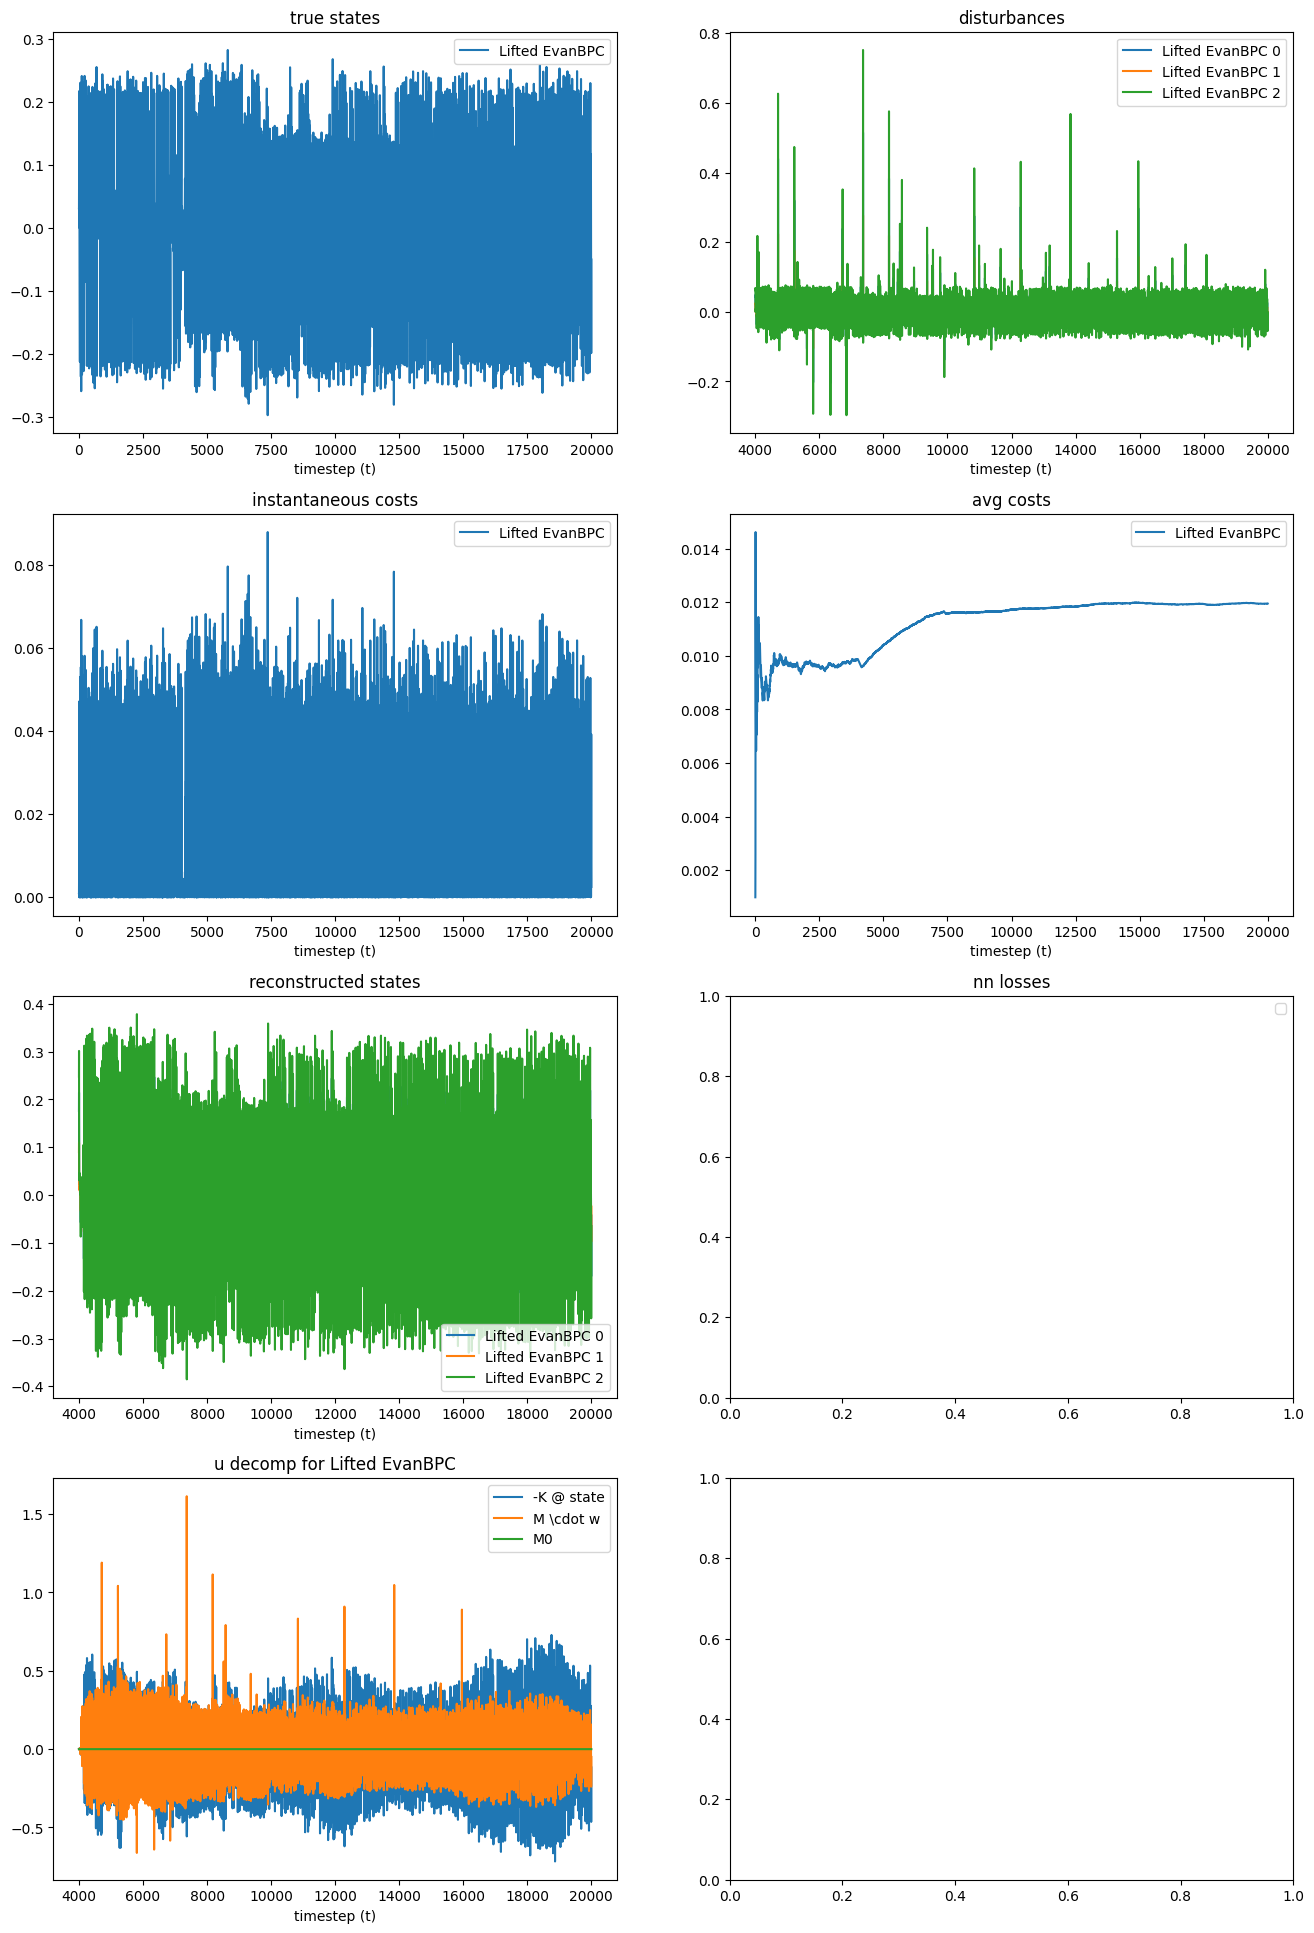

In [32]:
plot_gym(experiment)

### a